In [1]:
import wat
import ragnostic

import pathlib

data_dir = pathlib.Path("../data/")
document_paths = {
    'journal' : data_dir / 'journal' / 'JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
    'textbook' : data_dir / 'textbook' / 'TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
    'report' : data_dir / 'report' / 'REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
    'article': data_dir / 'article' / 'REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'
}
document_paths = {
    k : str(v.resolve())
    for k,v in document_paths.items()
}
document_paths

{'journal': '/home/nicholasgrundl/projects/ragnostic/data/journal/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
 'textbook': '/home/nicholasgrundl/projects/ragnostic/data/textbook/TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
 'report': '/home/nicholasgrundl/projects/ragnostic/data/report/REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
 'article': '/home/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'}

In [52]:
def get_js_zoom_code(zoom_style = 'modal', height: int=300)->tuple[str,str]:
    if zoom_style=='modal':
        js_code = """
        <script>
            function toggleZoomModal(img) {
                const container = img.parentElement;
                if (container.style.position !== 'fixed') {
                    // Zoom in
                    container.style.position = 'fixed';
                    container.style.top = '50%';
                    container.style.left = '50%';
                    container.style.transform = 'translate(-50%, -50%)';
                    container.style.zIndex = '1000';
                    container.style.background = 'rgba(0,0,0,0.8)';
                    container.style.padding = '20px';
                    img.style.height = '90vh';
                    img.style.cursor = 'zoom-out';
                } else {
                    // Zoom out
                    container.style.position = 'relative';
                    container.style.top = 'auto';
                    container.style.left = 'auto';
                    container.style.transform = 'none';
                    container.style.zIndex = 'auto';
                    container.style.background = 'none';
                    container.style.padding = '0';
                    img.style.height = '""" + str(height) + """px';
                    img.style.cursor = 'zoom-in';
                }
            }
        </script>
        """
        return ("toggleZoomModal", js_code)
    elif zoom_style=='expand':
        js_code="""
        <script>
        function toggleZoomExpand(img) {
            const originalHeight = """ + str(height) + """;
            const expandedHeight = originalHeight * 3;  // 3x larger
            
            if (img.style.height === originalHeight + 'px') {
                img.style.height = expandedHeight + 'px';
                img.style.zIndex = '10';
                img.style.cursor = 'zoom-out';
            } else {
                img.style.height = originalHeight + 'px';
                img.style.zIndex = '1';
                img.style.cursor = 'zoom-in';
            }
        }
        </script>
        """
        return ("toggleZoomExpand", js_code)

from IPython.display import display, HTML
import pymupdf
import base64

def get_pdf_preview_html(
    document_path: str,
    height: int = 300,
    gap: int = 10,
    padding: int = 10,
    background: str = "#f5f5f5",
    zoom_style='expand'
) -> str:
    """
    Display PDF pages in a horizontal scrollable container with zoom capability.
    
    Args:
        document_path: Path to the PDF file
        height: Height of the thumbnails in pixels
        gap: Space between pages in pixels
        padding: Container padding in pixels
        background: Background color of the container
        zoom_style: one of modal or expand
    """
    doc = pymupdf.open(document_path)
    
    # JavaScript for zoom functionality
    zoom_function_name, js_code = get_js_zoom_code(zoom_style = zoom_style, height=height)
    # Create HTML container
    html_content = f"""
    {js_code}
    <div style="display: flex; 
                overflow-x: auto; 
                gap: {gap}px; 
                padding: {padding}px; 
                background: {background};">
    """
    
    # Add each page
    for page_num, page in enumerate(doc, 1):
        pix = page.get_pixmap()
        img_bytes = pix.tobytes()
        img_base64 = base64.b64encode(img_bytes).decode()
        
        html_content += f"""
        <div style="flex: 0 0 auto; position: relative;">
            <img src="data:image/png;base64,{img_base64}"
                 onclick="{zoom_function_name}(this)"
                 style="height: {height}px;
                        border: 1px solid #ddd;
                        border-radius: 4px;
                        box-shadow: 2px 2px 5px rgba(0,0,0,0.1);
                        cursor: zoom-in;
                        transition: all 0.3s ease;">
            <div style="position: absolute; 
                        bottom: 5px; 
                        right: 5px; 
                        background: rgba(0,0,0,0.5);
                        color: white;
                        padding: 2px 6px;
                        border-radius: 3px;
                        font-size: 12px;">
                {page_num}
            </div>
        </div>
        """
    
    html_content += "</div>"
    return html_content

def preview_pdf(document_path: str, **kwargs)->None:
    pdf_preview_args = {
        k : v
        for k,v in kwargs.items()
        if k in ['height', 'gap', 'padding','background','zoom_style']
    }
    html_content = get_pdf_preview_html(
        document_path=document_path,
        height= 300,
        zoom_style='expand',
    )
    display(HTML(html_content))
    return None

In [63]:
import time

def get_elapsed_time(start, end, as_msg=False):
    seconds = end - start
    minutes = round(seconds/60,2)
    if as_msg:
        return f"{seconds:0.1f}s [{minutes:0.2f}min]"
    return seconds, minutes

In [66]:
from docling.document_converter import DocumentConverter
from docling_core.types.doc.document import DoclingDocument
def document_to_markdown(document: DoclingDocument, output_filepath: str = "output.md"):
    try:
        markdown_string = result.document.export_to_markdown()
        
        with open(output_filepath, "w", encoding="utf-8") as f:
            f.write(markdown_string)
            
        return markdown_string
    except UnicodeEncodeError as e:
        print(f"Unicode encoding error: {e}")
        print(f"Problematic character at position: {e.start}")
        raise
    except IOError as e:
        print(f"IO error while writing file: {e}")
        raise

# Docling

Converting /home/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf ...
Completed in 3.5s [0.06min]



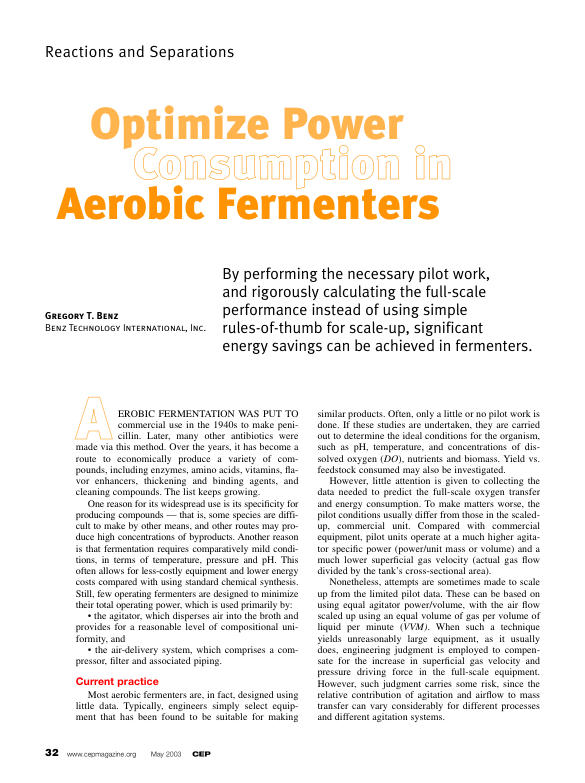
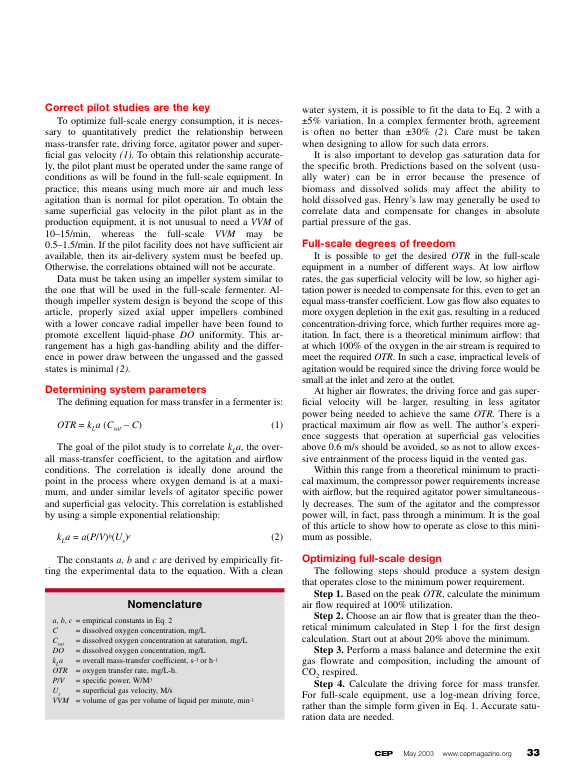
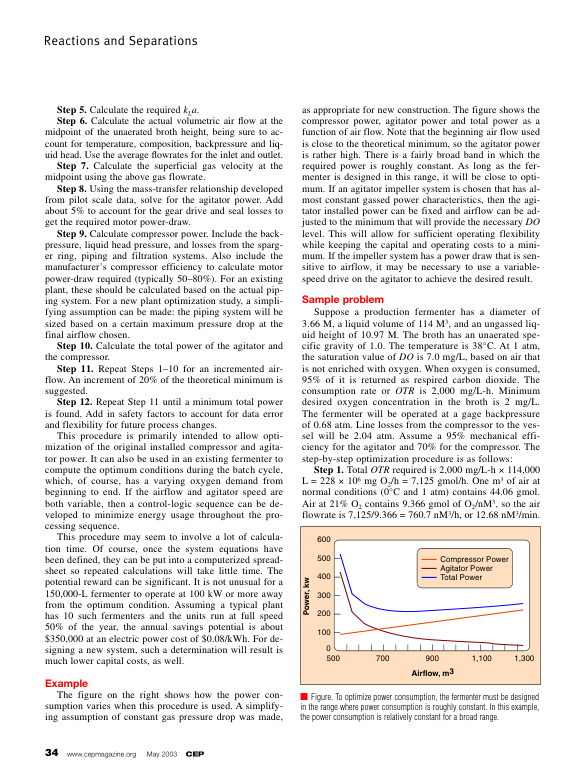
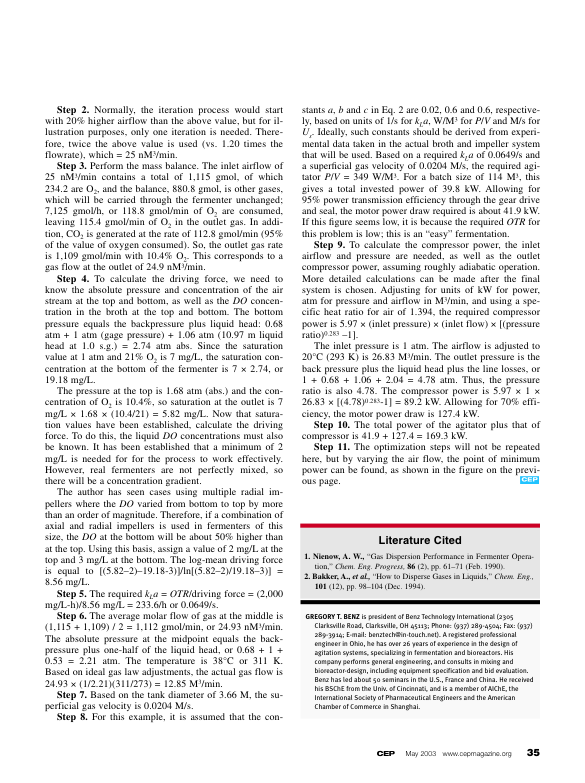

In [69]:
start = time.time()
document_kind = 'article'
source = document_paths[document_kind]
print(f"Converting {source} ...")
converter = DocumentConverter()
result = converter.convert(source)
document = result.document
end = time.time()

        
markdown = document_to_markdown(document, output_filepath = f"{document_kind}-docling.md")

print(f"Completed in {get_elapsed_time(start, end, as_msg=True)}")
preview_pdf(source)

Converting /home/nicholasgrundl/projects/ragnostic/data/journal/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf ...
Completed in 5.4s [0.09min]



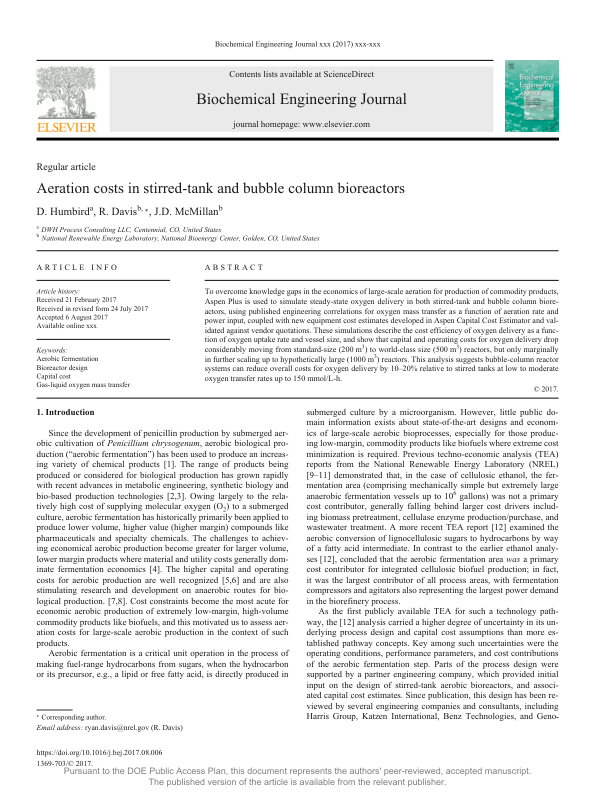
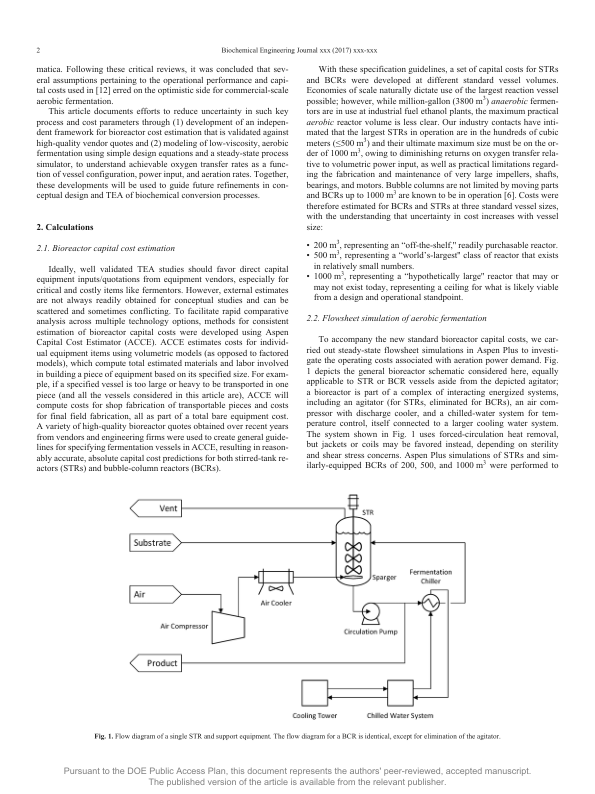
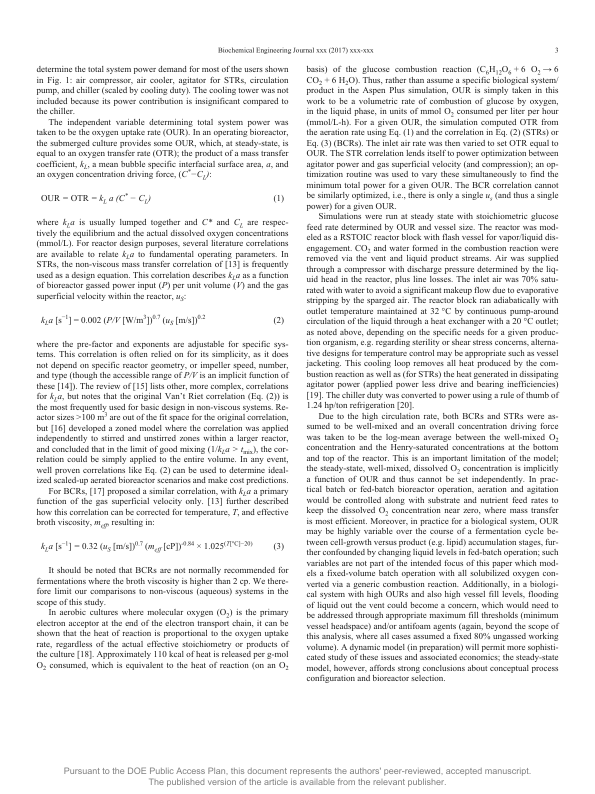
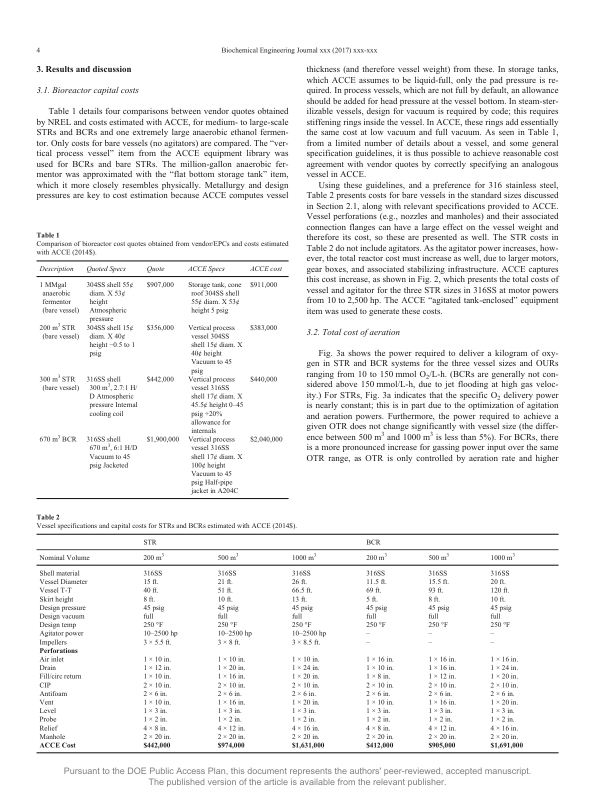
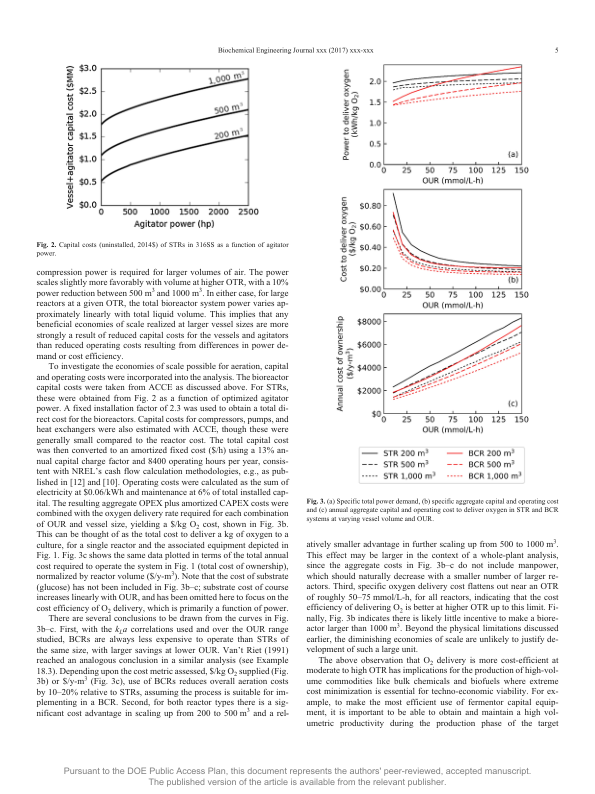
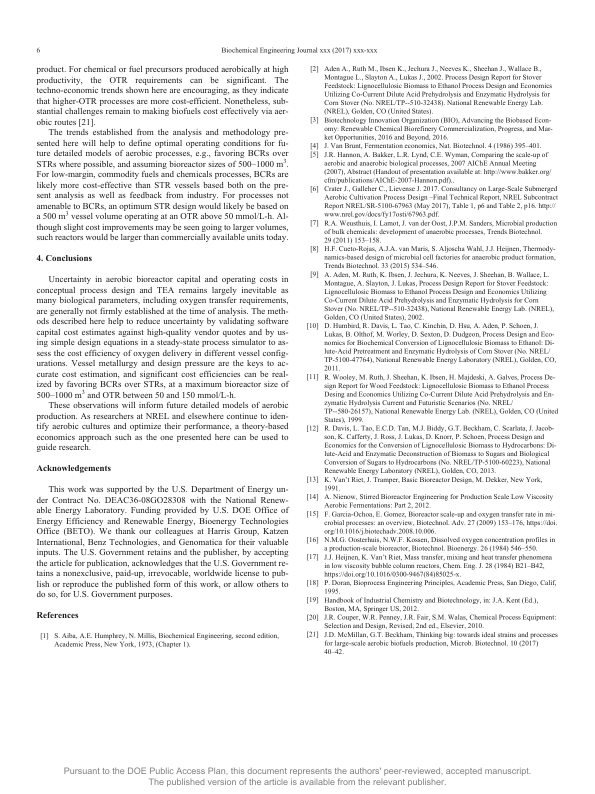

In [70]:
start = time.time()
document_kind = 'journal'
source = document_paths[document_kind]
print(f"Converting {source} ...")
converter = DocumentConverter()
result = converter.convert(source)
document = result.document
end = time.time()

        
markdown = document_to_markdown(document, output_filepath = f"{document_kind}-docling.md")

print(f"Completed in {get_elapsed_time(start, end, as_msg=True)}")
preview_pdf(source)

Converting /home/nicholasgrundl/projects/ragnostic/data/report/REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf ...
Completed in 8.1s [0.14min]



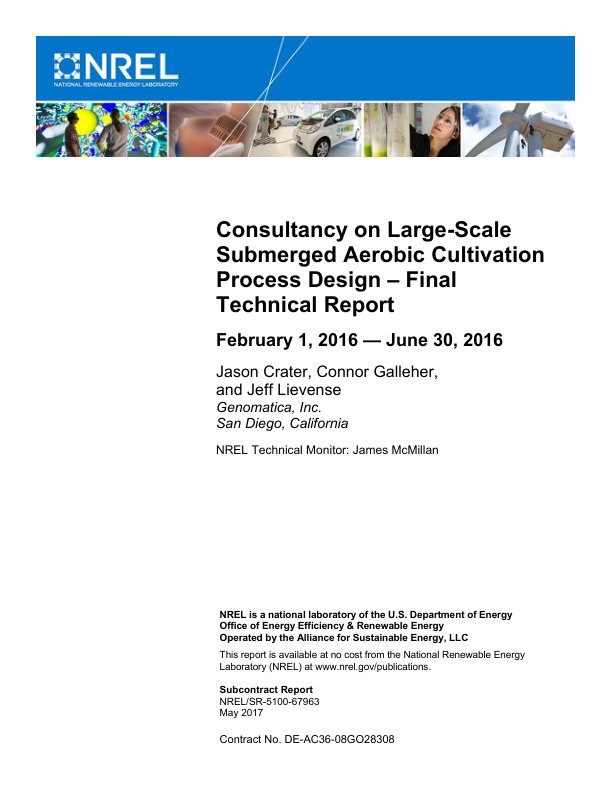
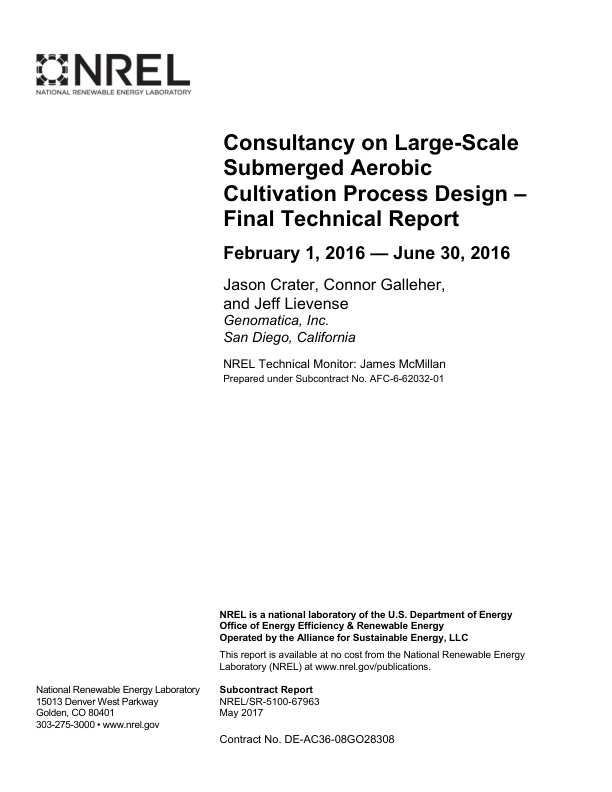
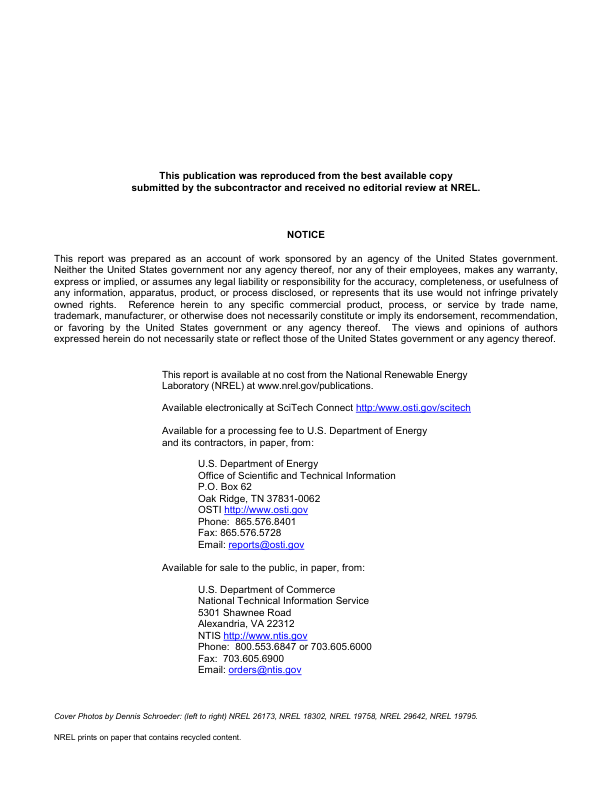
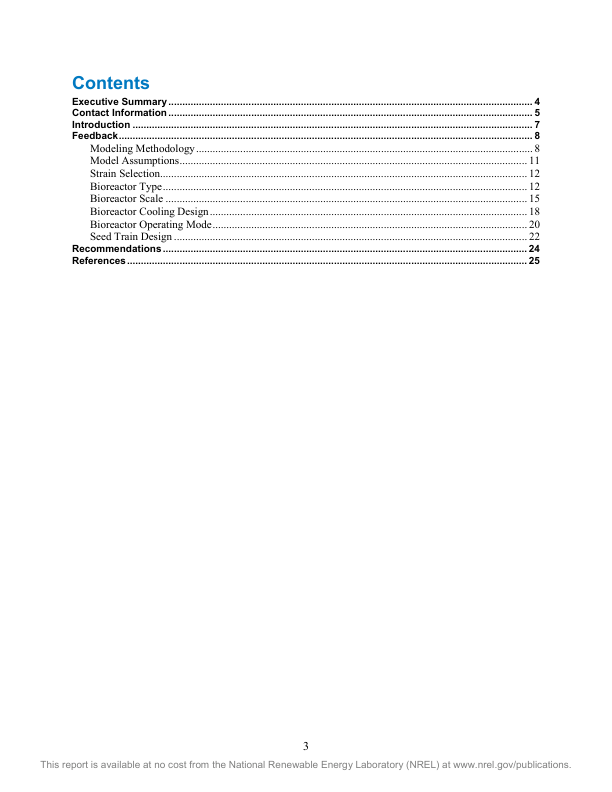
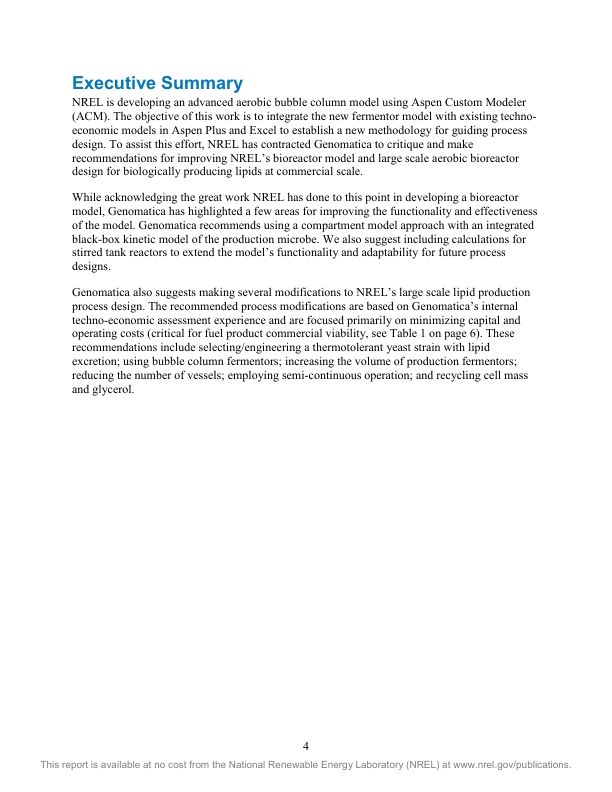
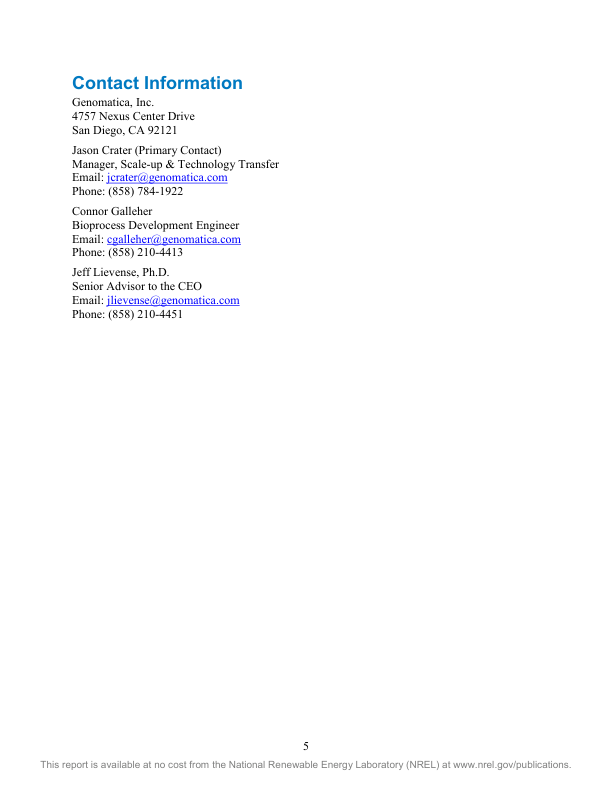
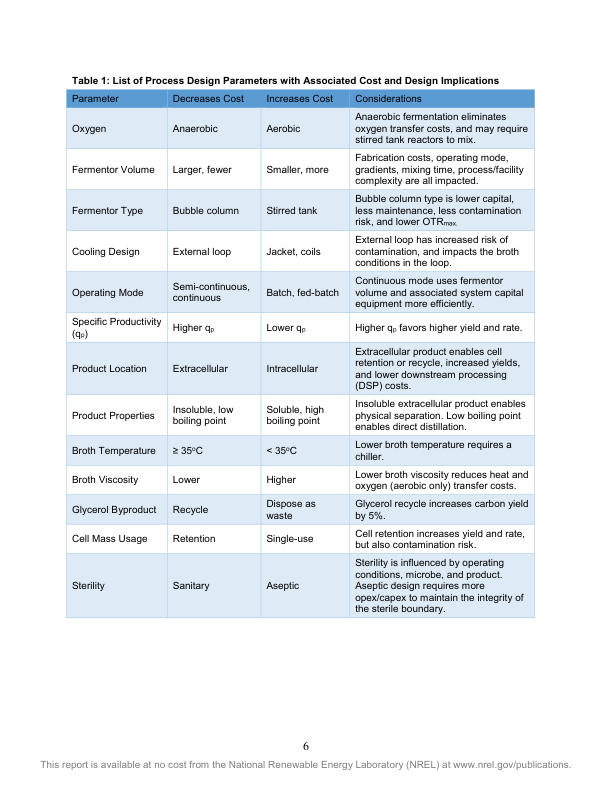
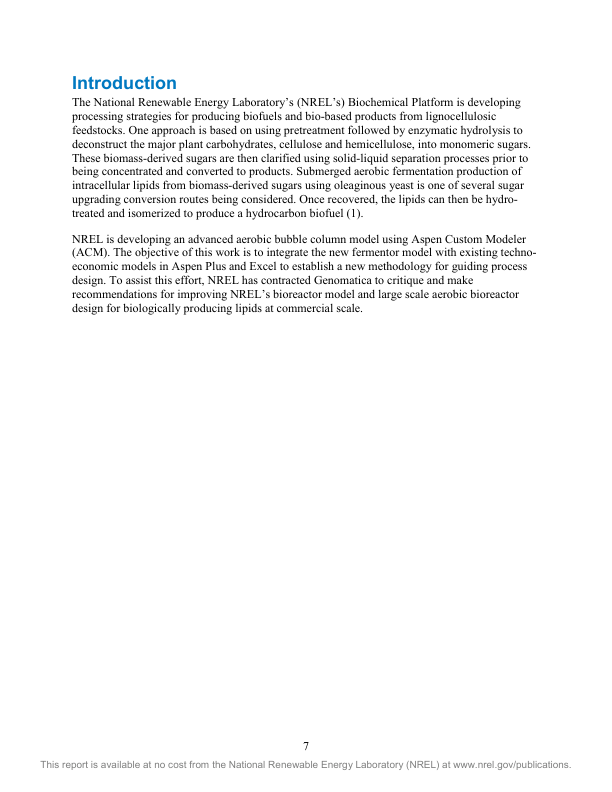
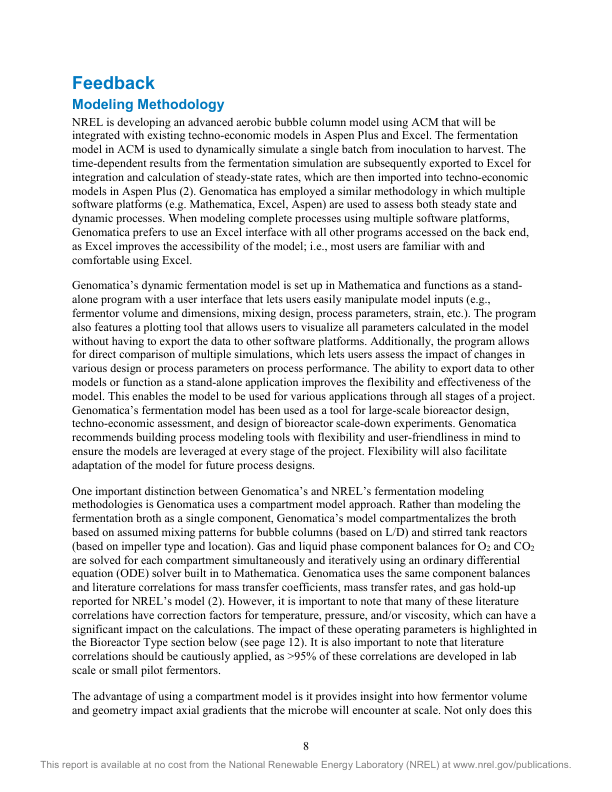
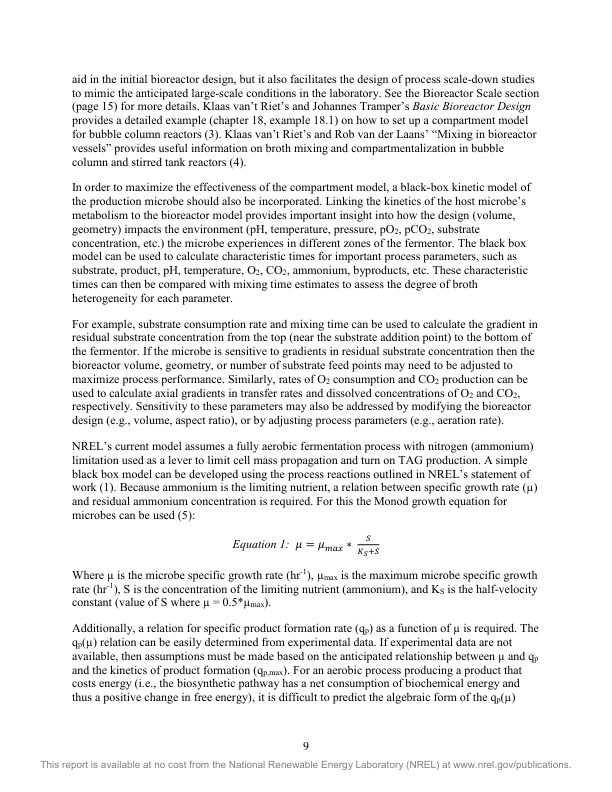
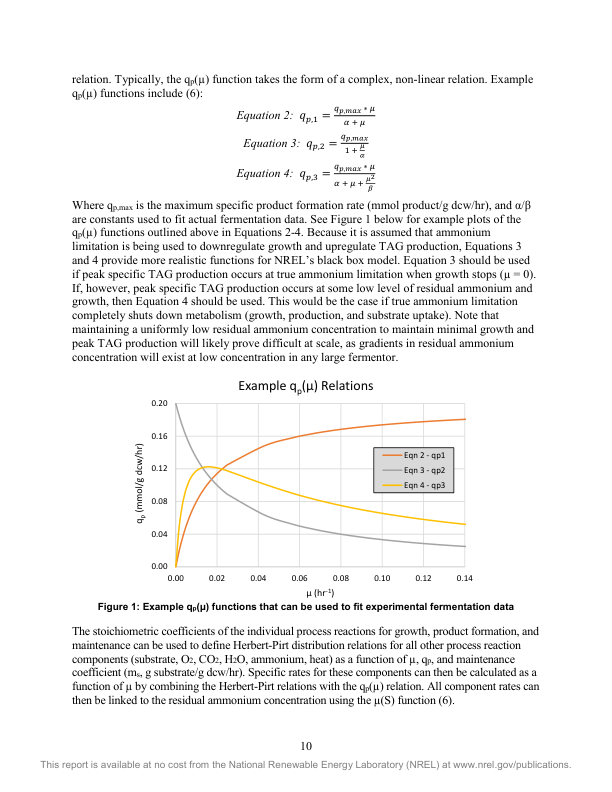
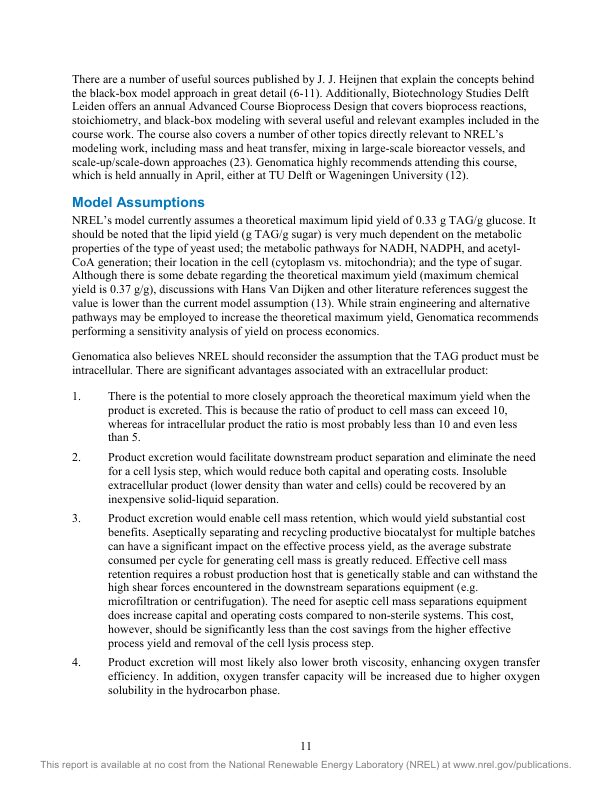
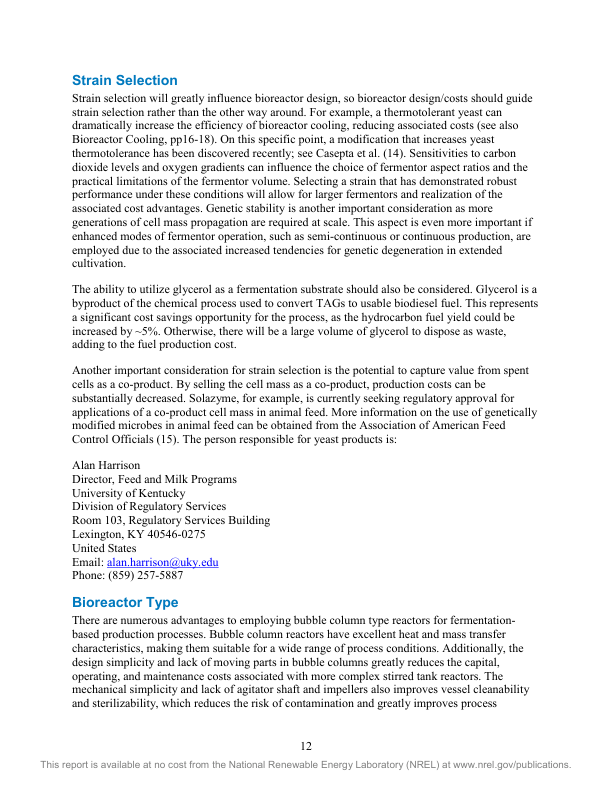
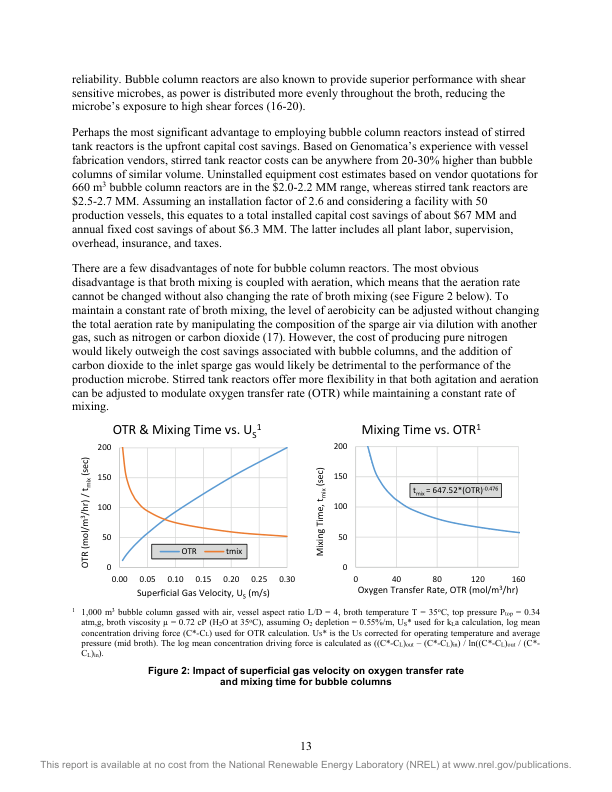
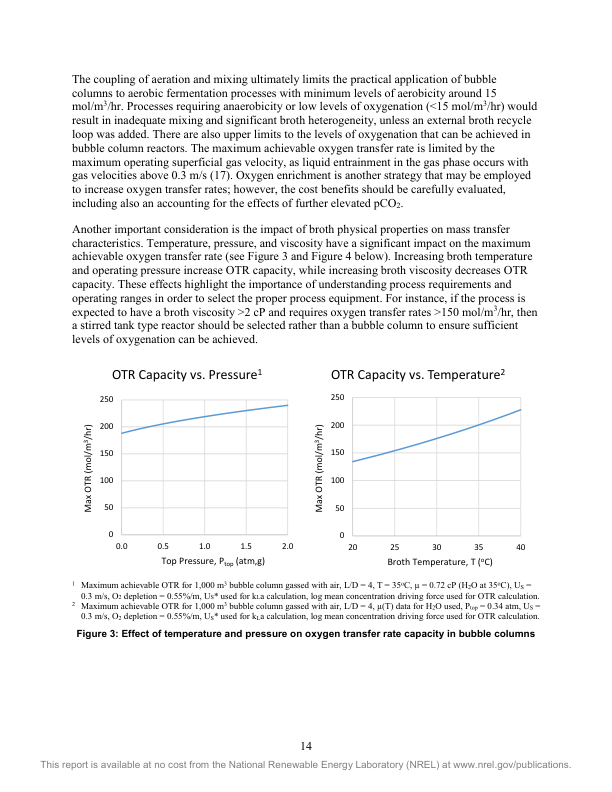
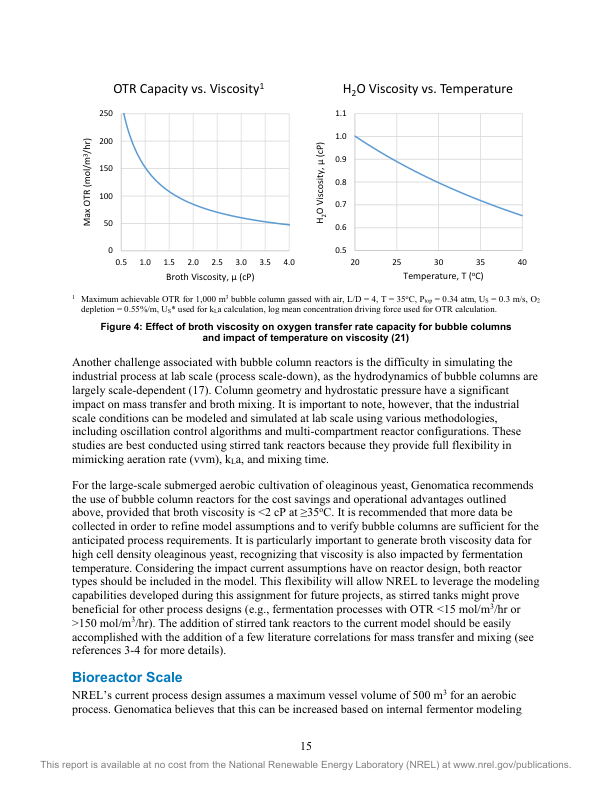
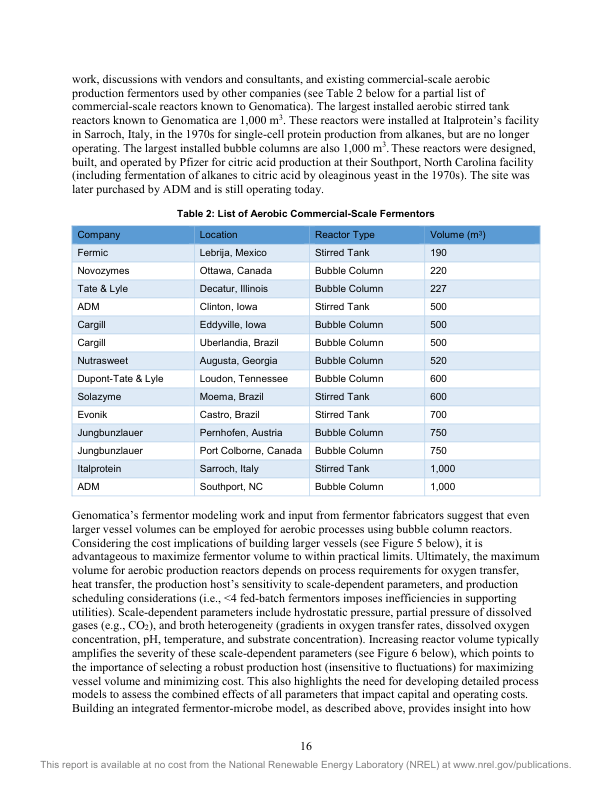
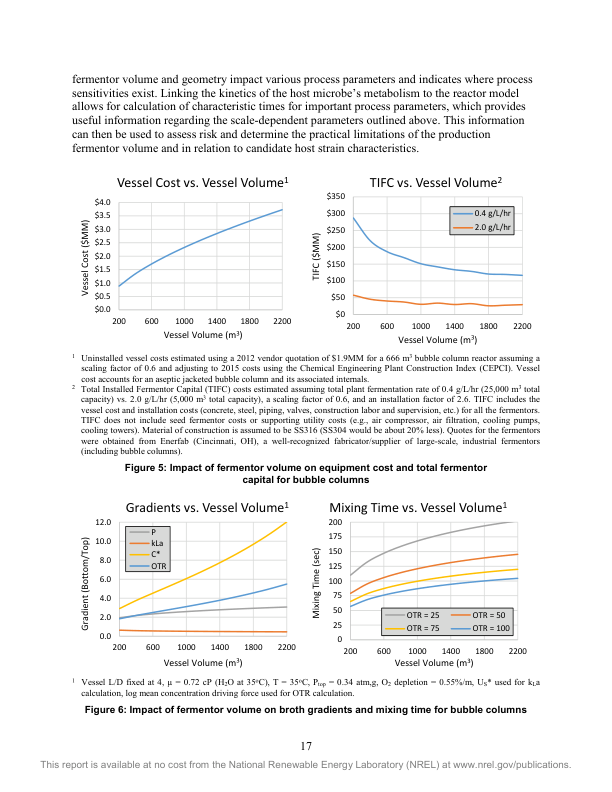
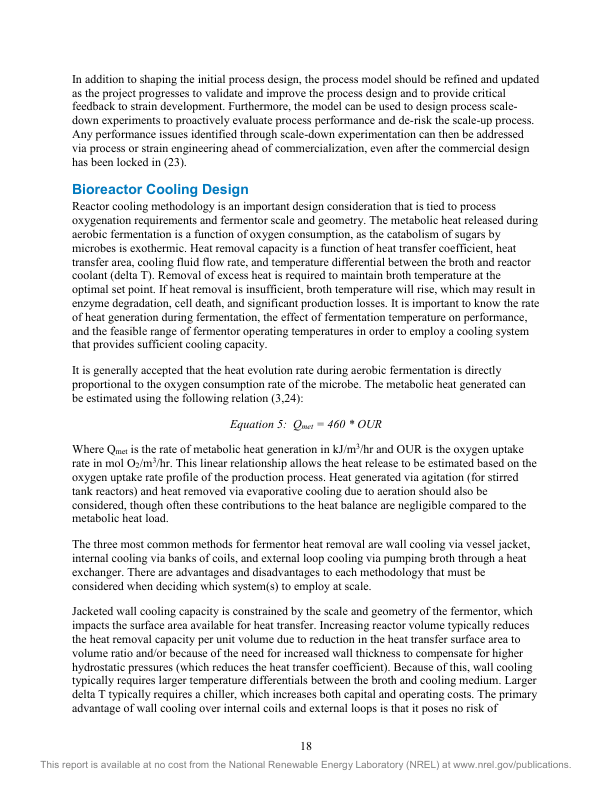
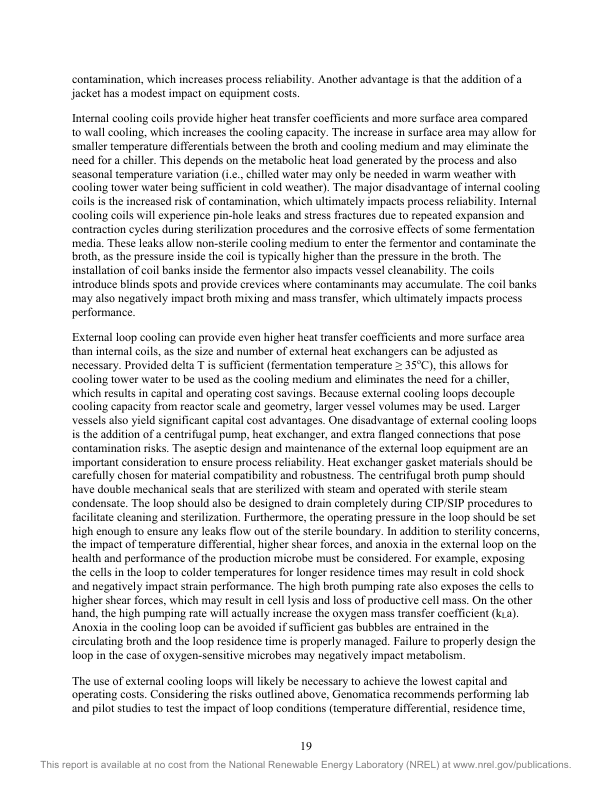
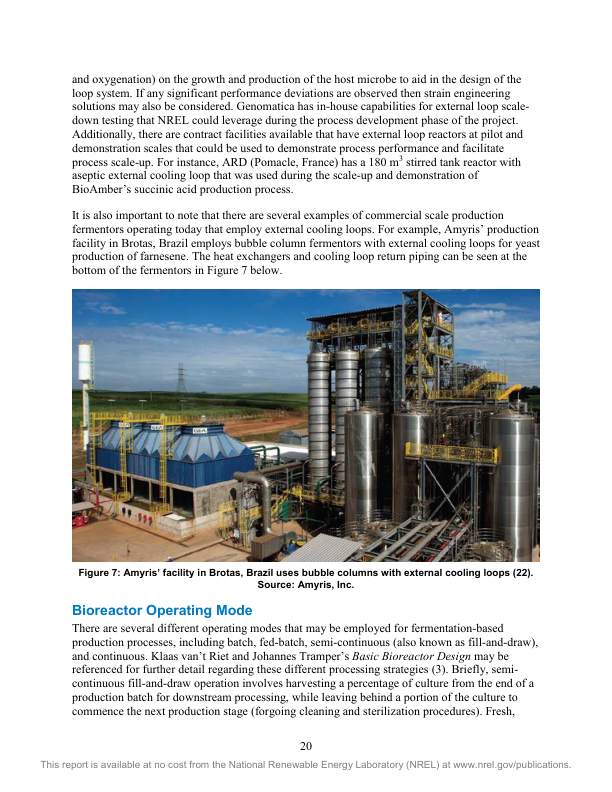
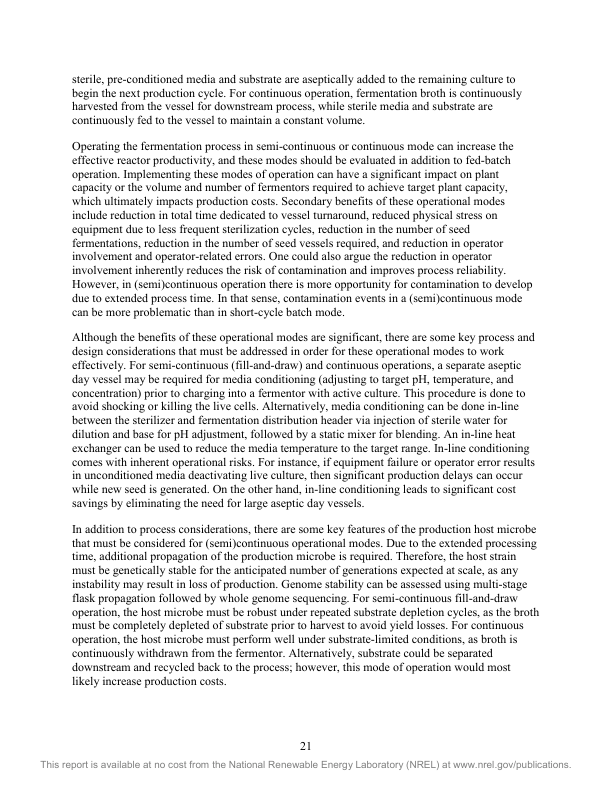
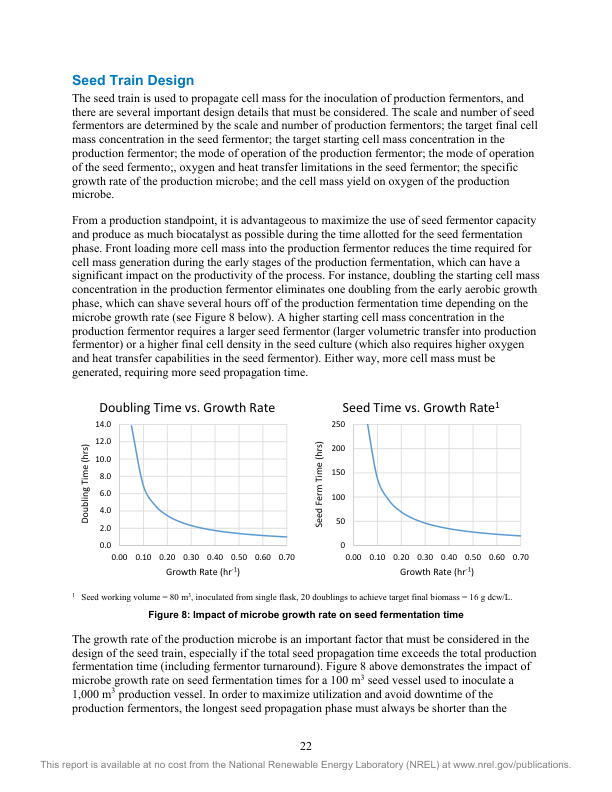
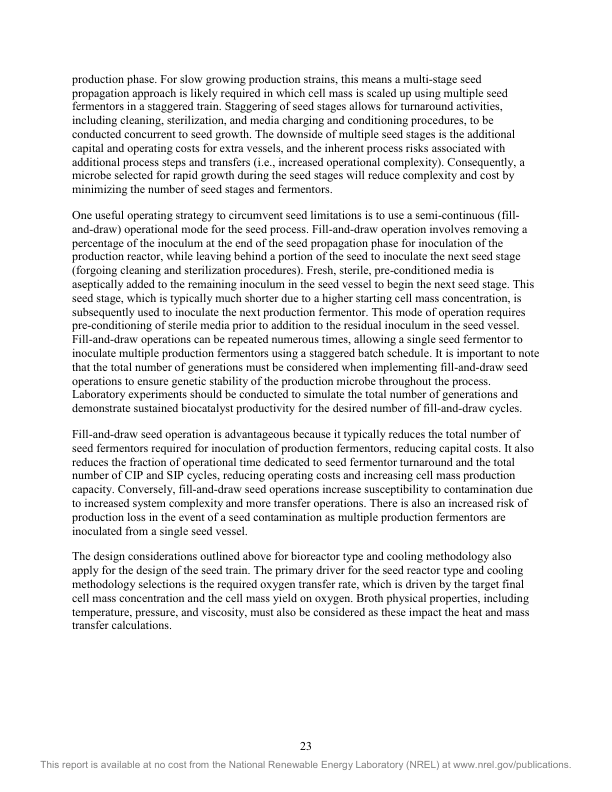
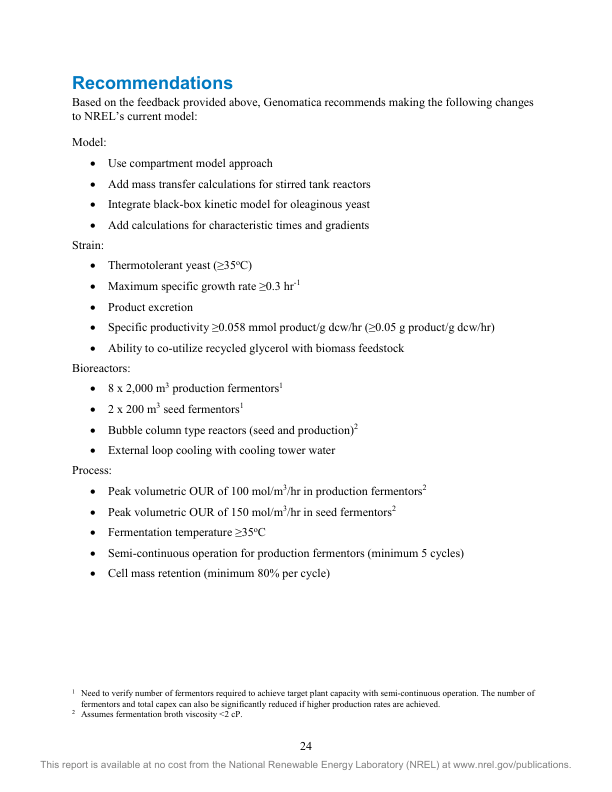
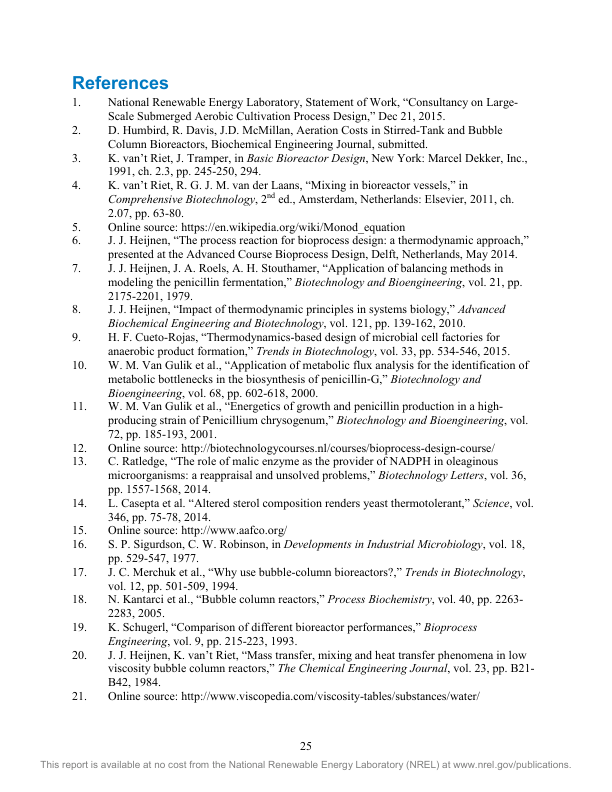
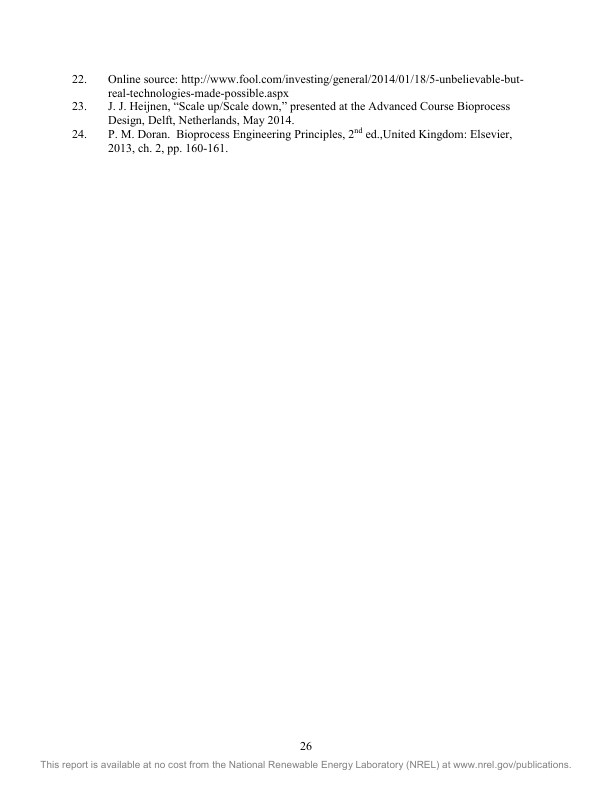

In [71]:
start = time.time()
document_kind = 'report'
source = document_paths[document_kind]
print(f"Converting {source} ...")
converter = DocumentConverter()
result = converter.convert(source)
document = result.document
end = time.time()

        
markdown = document_to_markdown(document, output_filepath = f"{document_kind}-docling.md")

print(f"Completed in {get_elapsed_time(start, end, as_msg=True)}")
preview_pdf(source)

Converting /home/nicholasgrundl/projects/ragnostic/data/textbook/TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf ...
Completed in 11.0s [0.18min]



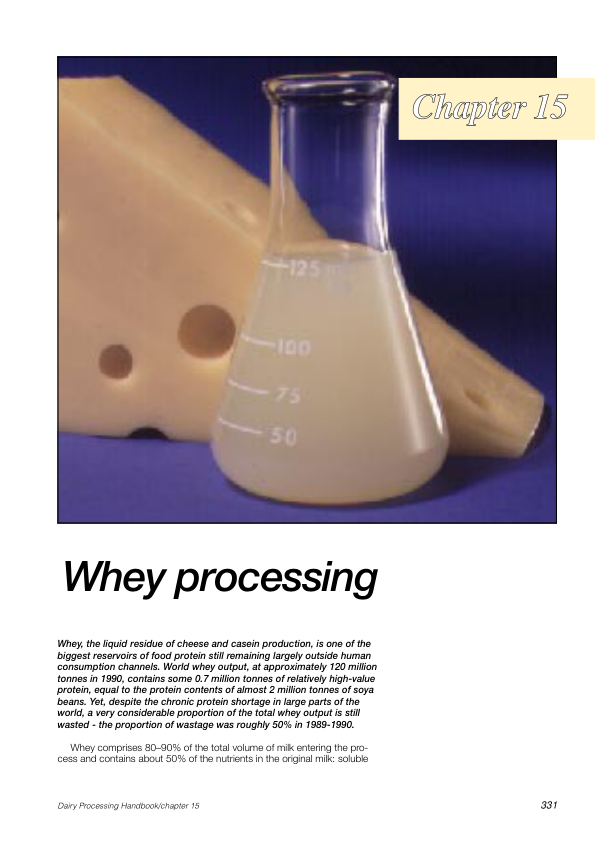
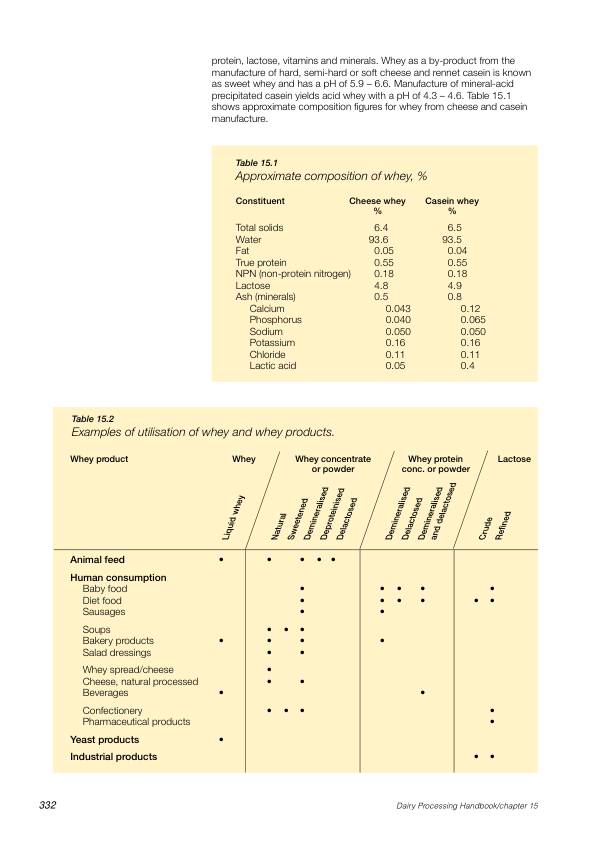
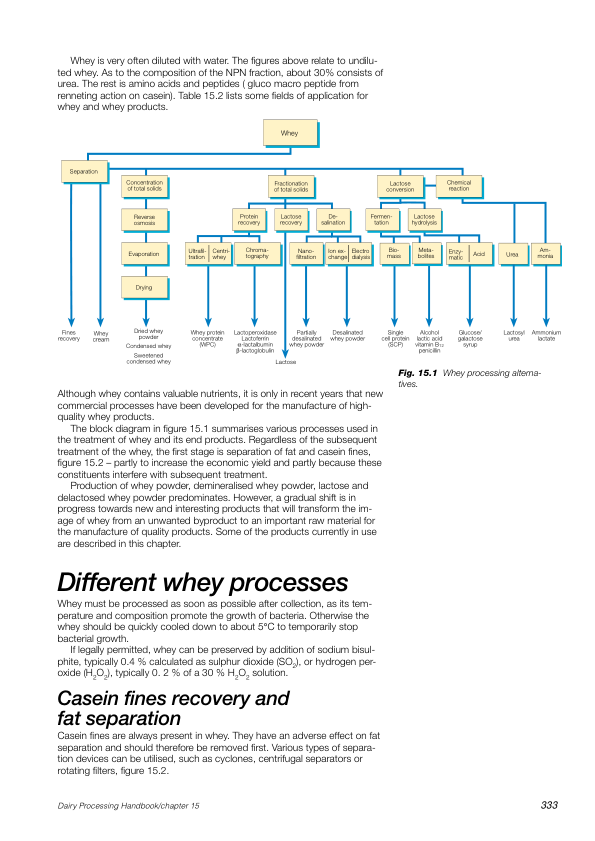
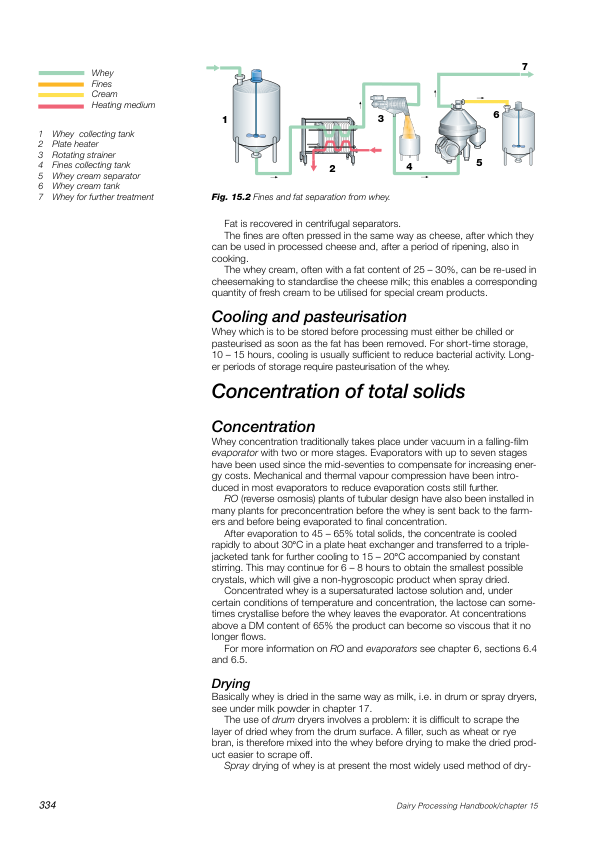
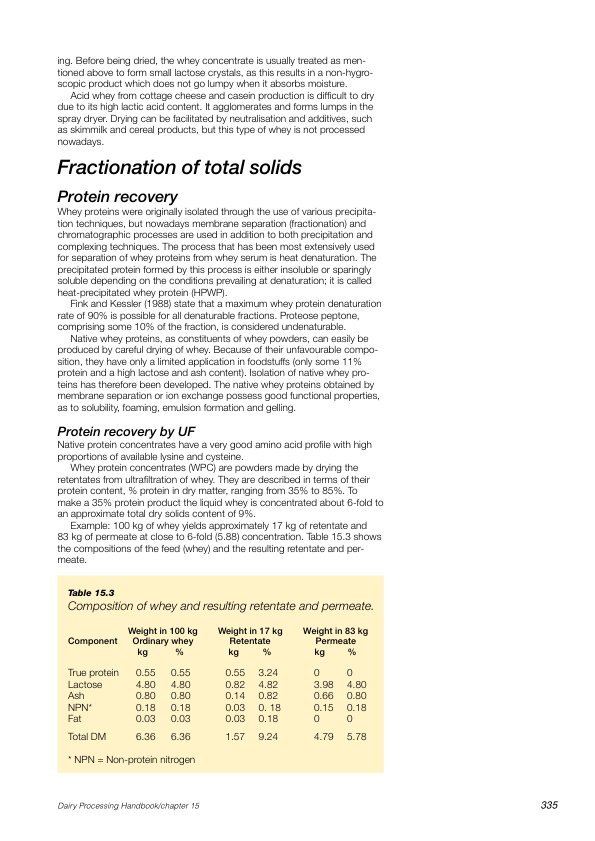
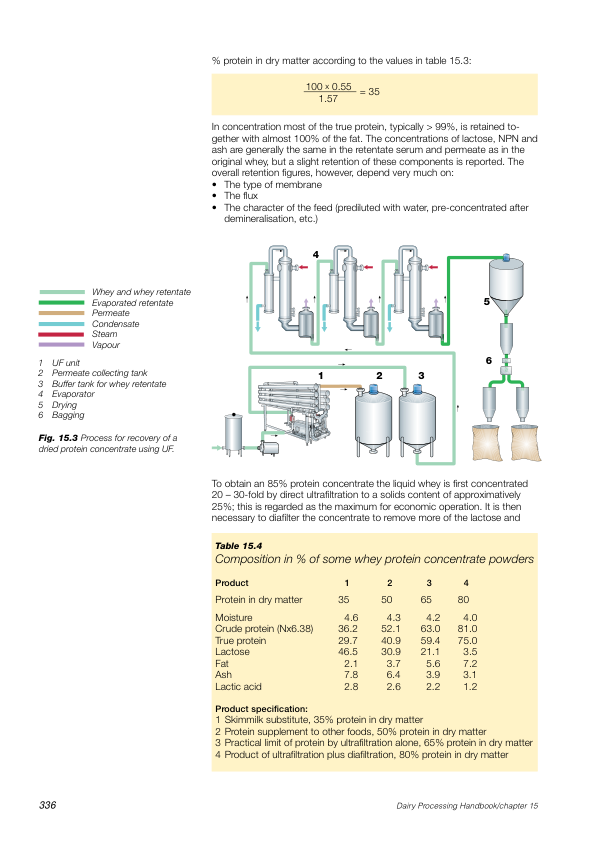
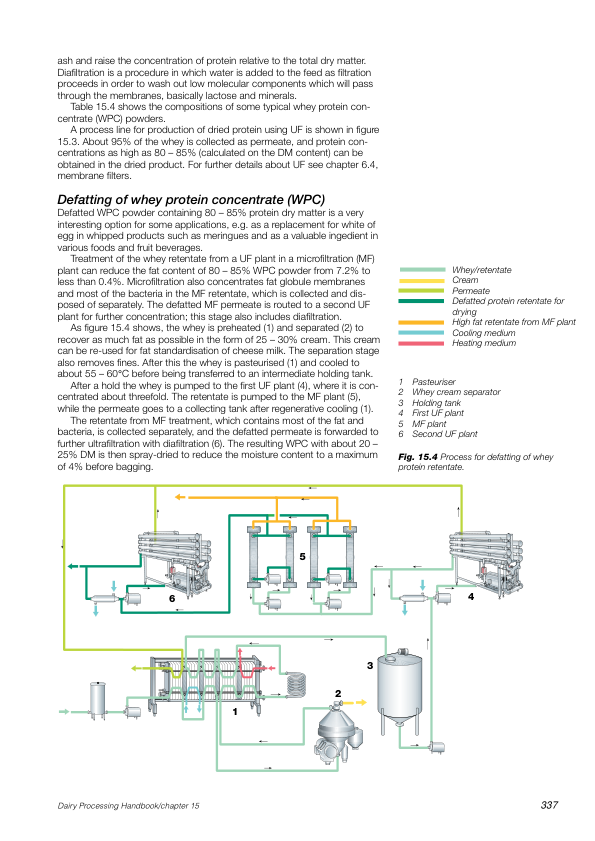
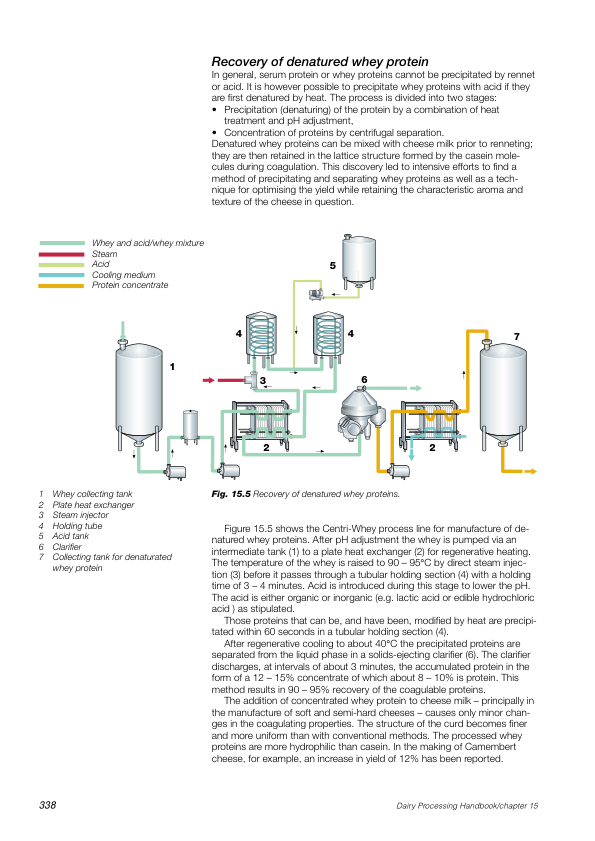
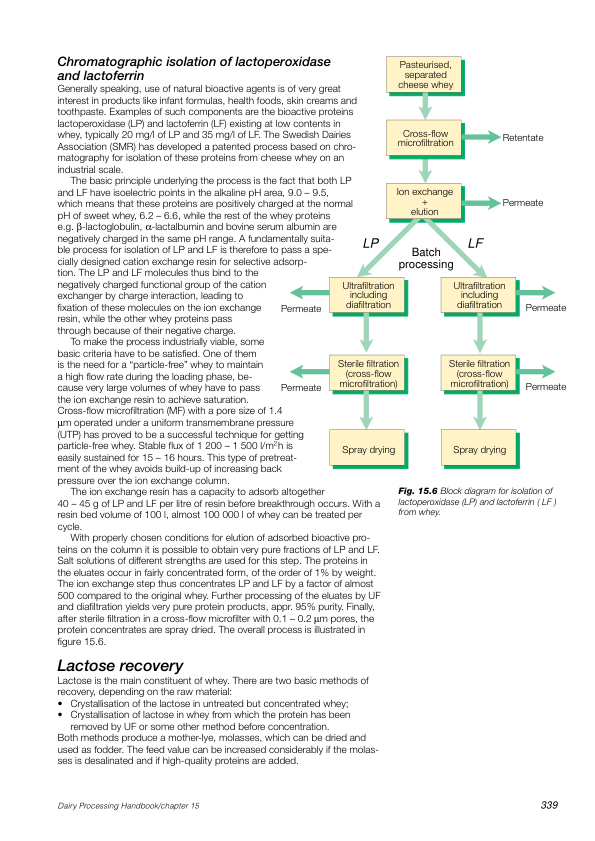
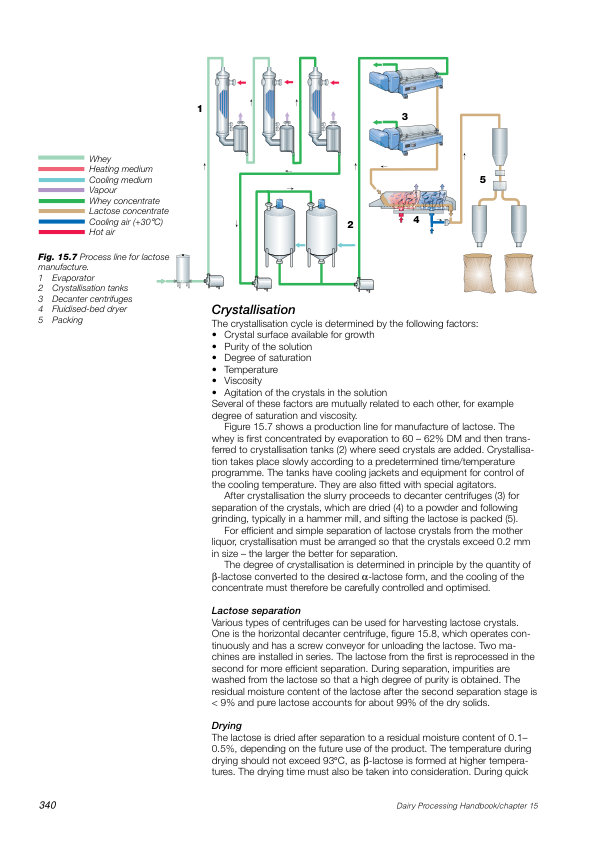
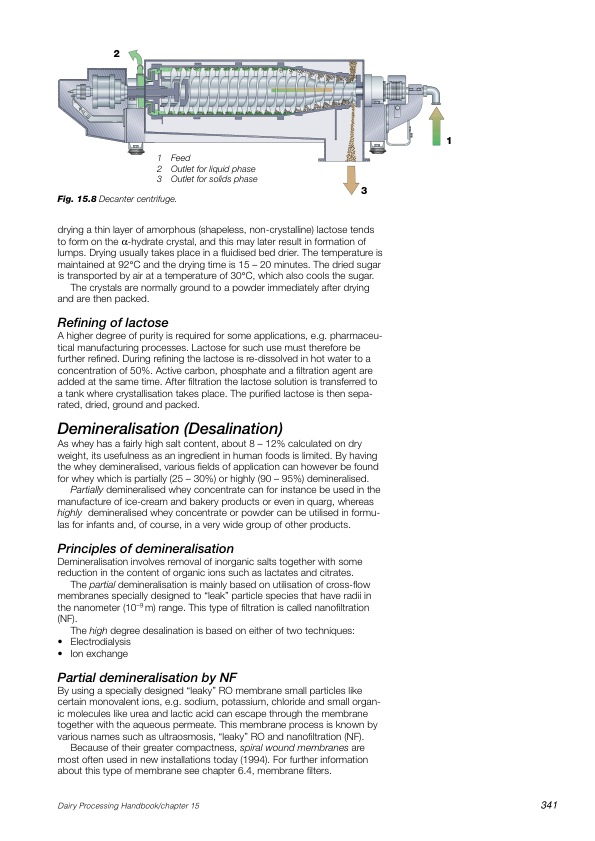
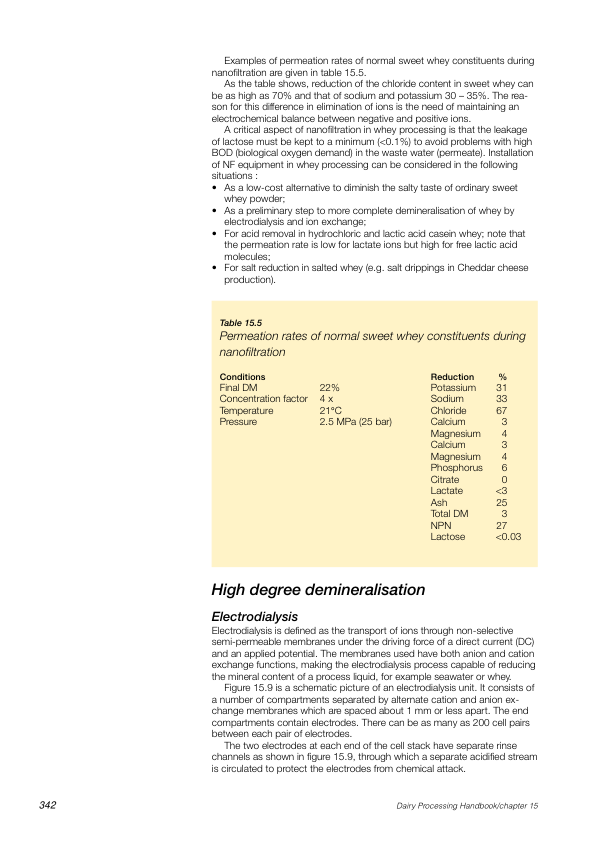
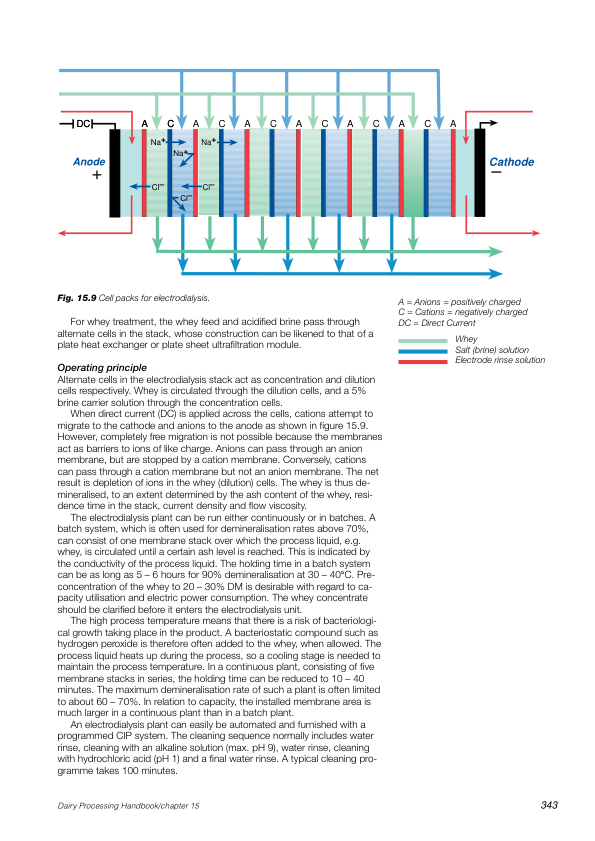
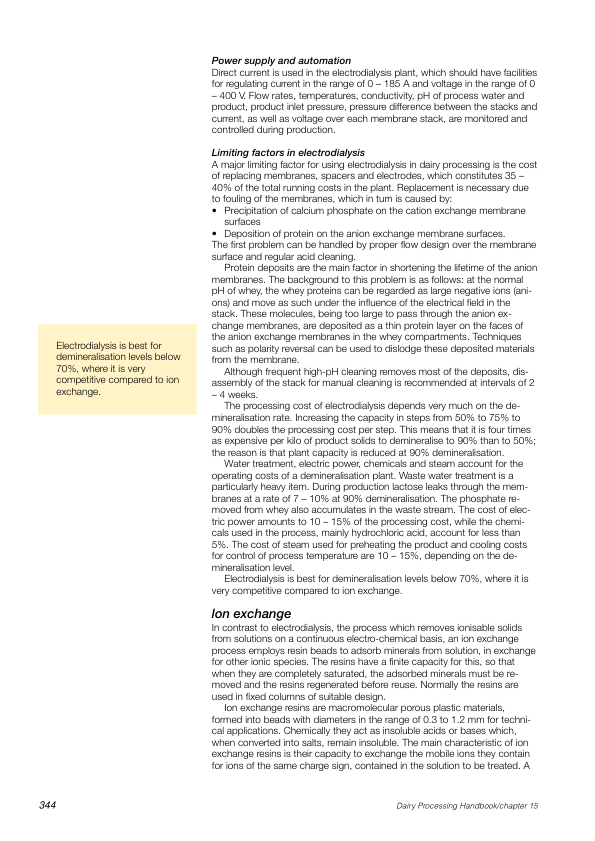
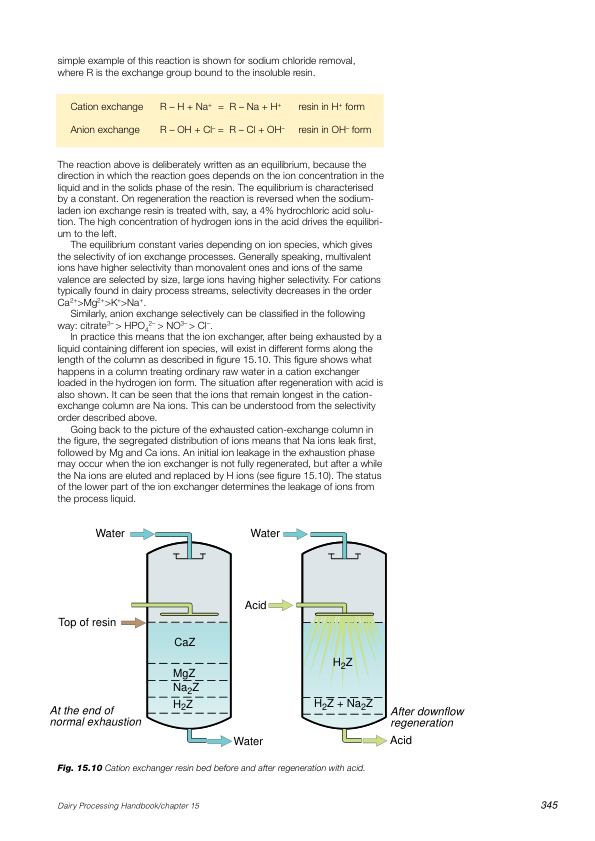
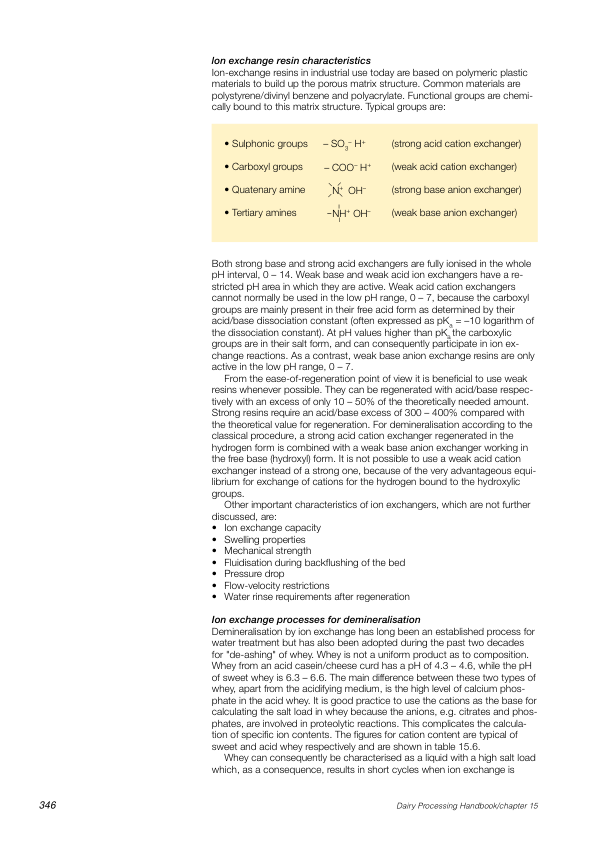
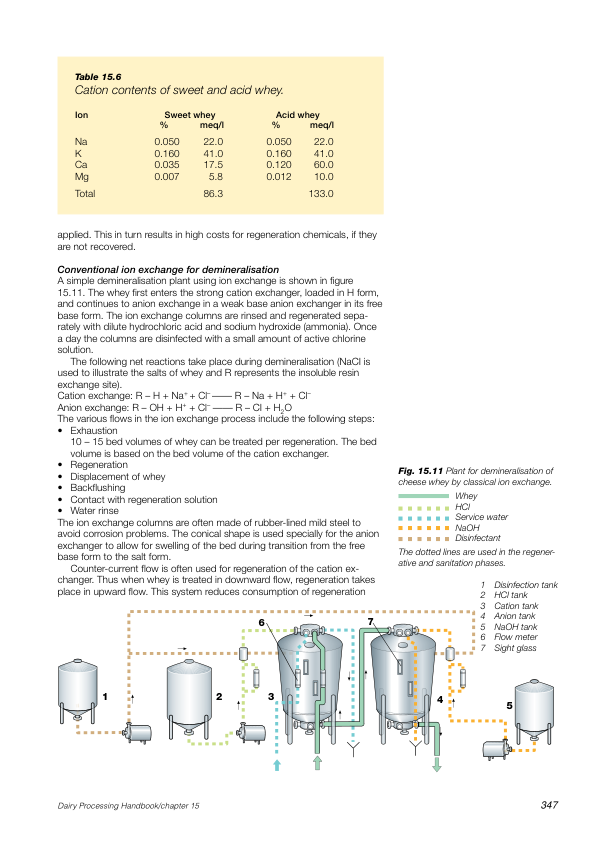
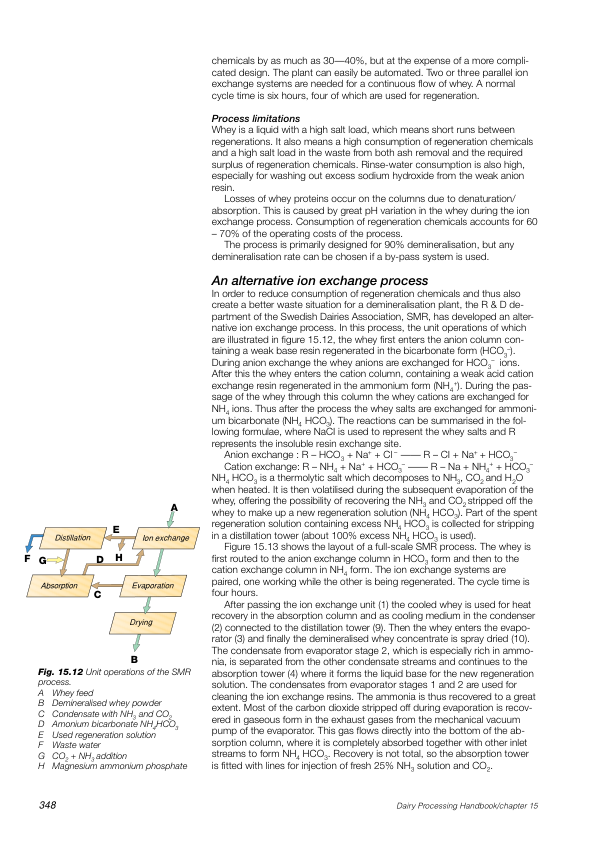
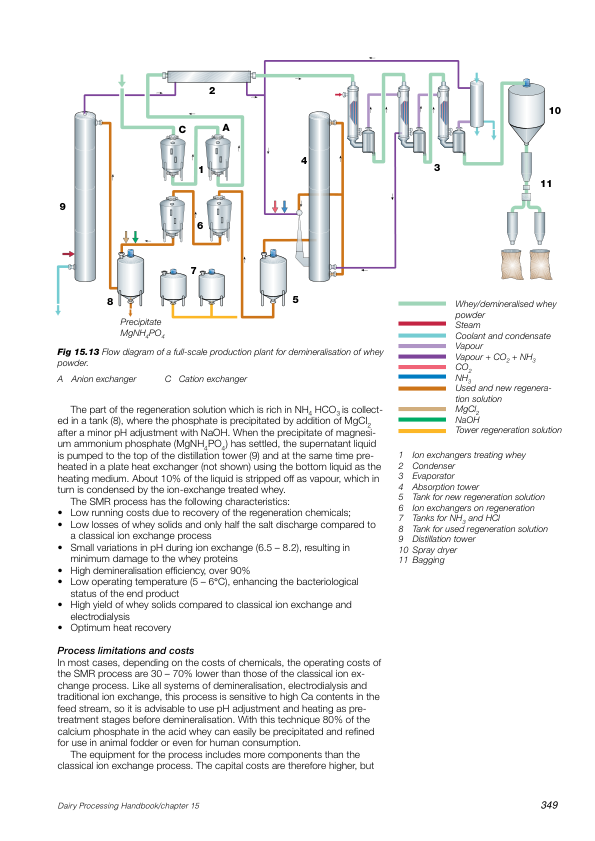
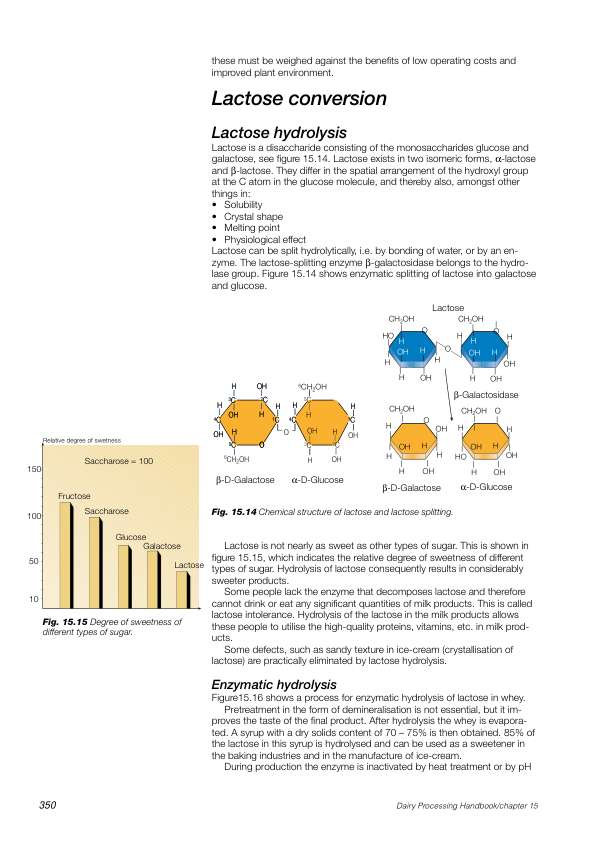
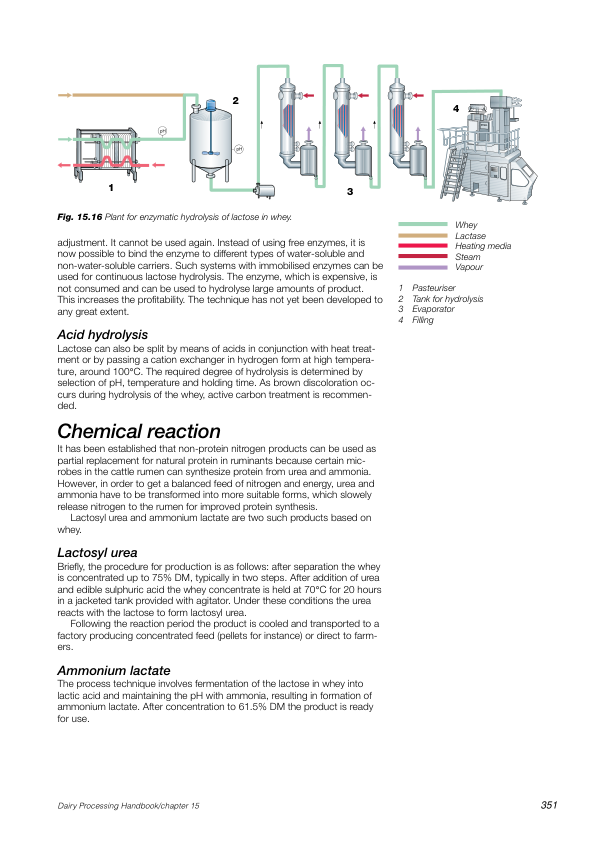
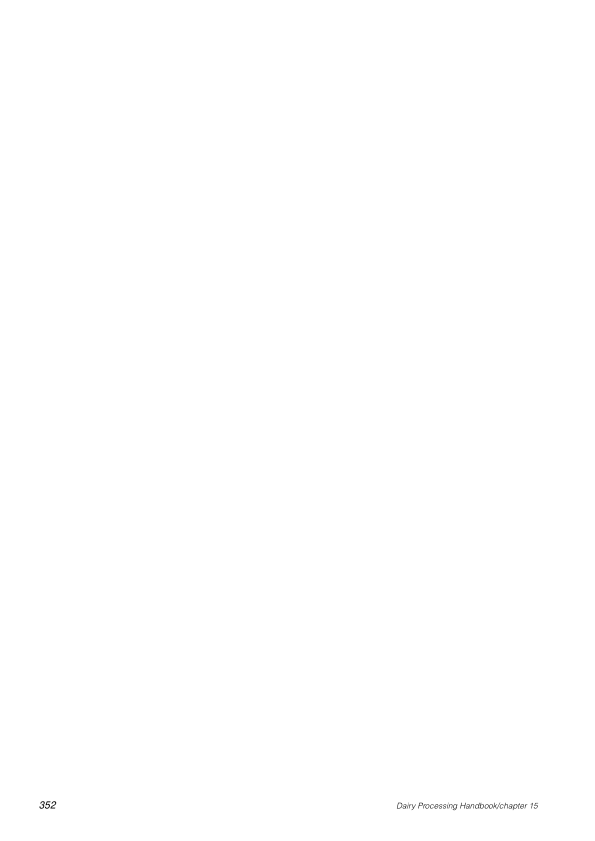

In [72]:
start = time.time()
document_kind = 'textbook'
source = document_paths[document_kind]
print(f"Converting {source} ...")
converter = DocumentConverter()
result = converter.convert(source)
document = result.document
end = time.time()

        
markdown = document_to_markdown(document, output_filepath = f"{document_kind}-docling.md")

print(f"Completed in {get_elapsed_time(start, end, as_msg=True)}")
preview_pdf(source)